In [ ]:
from numpy import nan
from numpy import isnan
import numpy as np
from pandas import read_csv
from pandas import to_numeric
import pandas as pd

# Ts smoother function
from statsmodels.tsa.seasonal import STL
from supersmoother import SuperSmoother

In [ ]:
df1 = pd.read_csv("/filepathcoverd/DailyDelhiClimateTrain.csv")
df2 = pd.read_csv("/filepathcoverd/DailyDelhiClimateTest.csv")

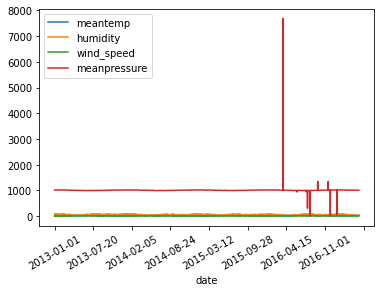

In [ ]:
df = df1.append(df2)
df.set_index('date').plot(rot = 30)

In [ ]:
df.to_csv("/filepathcoverd/DailyDelhiClimate.csv", index = False)

In [ ]:
# fill missing values with a value at the same time one day ago
def fill_missing(values):
	one_day = 60 * 24
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if isnan(values[row, col]):
				values[row, col] = values[row - one_day, col]
 
# load all data
# dataset = read_csv('/dbfs/FileStore/shared_uploads/wendyan@microsoft.com/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

dataset = read_csv("/filepathcoverd/DailyDelhiClimate.csv", infer_datetime_format=True,  index_col=['date'])

# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')
# fill missing
fill_missing(dataset.values)
# add a column for for the remainder of sub metering
values = dataset.values
dataset = dataset.reset_index()
dataset = dataset.rename(columns = {'date': 'datetime'})
dataset.to_csv("/filepathcoverd/DailyDelhiClimate.csv", index = False)

datapath = "/filepathcoverd/DailyDelhiClimate.csv"

In [ ]:
# Set the target variable to be humidity

dataset = read_csv("/filepathcoverd/DailyDelhiClimate.csv")
dataset = dataset[['datetime', 'humidity', 'meantemp', 'wind_speed', 'meanpressure']]

dataset.to_csv("/filepathcoverd/DailyDelhiClimate.csv", index = False)

In [ ]:
dataset = pd.read_csv("/filepathcoverd/DailyDelhiClimate.csv")
dataset= dataset.drop_duplicates('datetime')

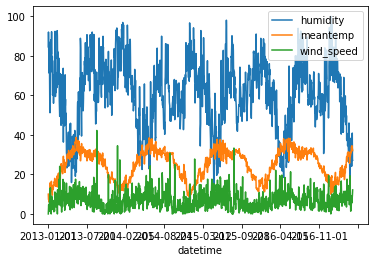

In [ ]:
dataset[['datetime', 'humidity', "meantemp", "wind_speed"]].set_index('datetime').plot()

In [ ]:
def imputeTSOutliers(dfTSData, col, iterations=2, outlier_threshold= 0.6):
    # See tsoutliers https://www.rdocumentation.org/packages/forecast/versions/8.12/source
  
  def impute_ts_outliers_item(dfItem):
    # sort by date and time
    dfItem = dfItem.sort_values('datetime')
    dfItem = dfItem.set_index('datetime')
    # Follow Hyndman's code to test for and remove seasonality
    # if seasonality is strong, remove seasonality
    # set index frequency
    dfItem = dfItem.asfreq('D')
    stl_decomp = STL(dfItem).fit()
    trend = stl_decomp.trend
    rem = stl_decomp.resid
    season = stl_decomp.seasonal
    detrend = dfItem.subtract(trend, axis=0)
    strength = 1 - rem.var() / detrend.var()
    
    if strength[0] >= outlier_threshold:
      dfItem = rem.add(trend, axis=0)
    else:
      dfItem = dfItem[col]

    # Smooth the seasonally adjusted data
    t = np.arange(len(dfItem))
    y = dfItem.values.flatten()
    ss = SuperSmoother()
    x = np.arange(len(dfItem))
    smoothed_vals = ss.fit(t, y).predict(t)

    # Find outliers from residuals
    resid = dfItem - smoothed_vals
    resid_q = np.quantile(resid, [0.25, 0.75])
    iqr = resid_q[1] - resid_q[0]
    limits = resid_q + 3 * iqr * np.array([-1, 1])

    # replace with NAN
    na_idx = resid[(resid < limits[0]) | (resid > limits[1])].dropna().index

    smoothed_vals = pd.Series(smoothed_vals)
    smoothed_vals.index = dfItem.index

    na_big = resid[(resid > limits[1])].index
    dfItem.loc[na_big, ] = smoothed_vals.loc[na_big, ] + limits[1]
#     dfItem.loc[na_big, ] = smoothed_vals.loc[na_big, ]
  
    na_small = resid[(resid < limits[0])].index
    dfItem.loc[na_small, ] = smoothed_vals.loc[na_small, ] + limits[0]
#     dfItem.loc[na_small, ] = smoothed_vals.loc[na_small, ]
  
    if strength[0] >= outlier_threshold:
      dfItem = dfItem.add(season, axis = 0)

    return dfItem.reset_index()
  dfSmoothedTsData = dfTSData.copy()
  for _ in range(iterations):
    dfSmoothedTsData = impute_ts_outliers_item(dfSmoothedTsData)
    dfSmoothedTsData.columns = ['datetime', col]
  dfSmoothedTsData.index = pd.Index(range(len(dfSmoothedTsData)))
  return dfSmoothedTsData

In [ ]:
for col in dataset.columns[1:]:
  temp = dataset[['datetime', col]]
  values = imputeTSOutliers(temp, col, iterations=2, outlier_threshold= 0.6)
  dataset[col] = values[col]

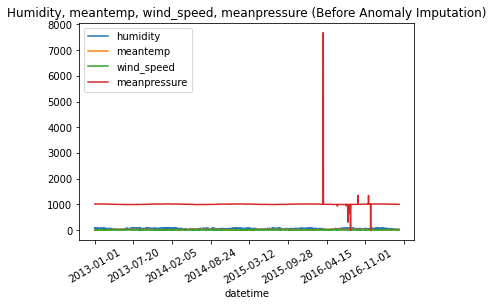

In [ ]:
dataset.set_index('datetime').plot(rot = 30, title = 'Humidity, meantemp, wind_speed, meanpressure (Before Anomaly Imputation)')

In [ ]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [ ]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[2:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

In [ ]:
# split into standard weeks
from numpy import split
from numpy import array
from pandas import read_csv
 
# split a univariate dataset into train/test sets
# There are 178 weeks in training and 46 weeks in testing
def split_dataset(data):
	# split into standard weeks
	train, test = data[2:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test
 
# load the new file
dataset = read_csv(datapath, header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(178, 7, 4)
87.0 42.2
(46, 7, 4)
35.3125 27.333334000000004

In [ ]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [ ]:

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [ ]:

# univariate multi-step cnn
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
X, y = to_supervised(train, 14, 7)

In [ ]:
train.shape

Out[153]: (178, 7, 4)

In [ ]:
X.shape

Out[154]: (1226, 14, 4)

In [ ]:
y.shape

Out[156]: (1226, 7)

In [ ]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)
 
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 20, 4
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(10, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model
 
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat
 
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores
 

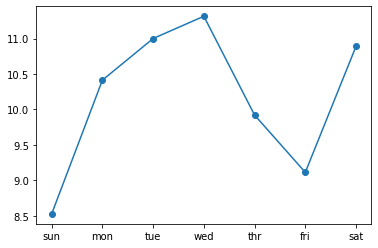

In [ ]:
# load the new file
dataset = read_csv(datapath, header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)

# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

In [ ]:
score

Out[138]: 10.214319240101942

In [ ]:
np.mean([i**2 for i in scores])

Out[144]: 104.33231753871675

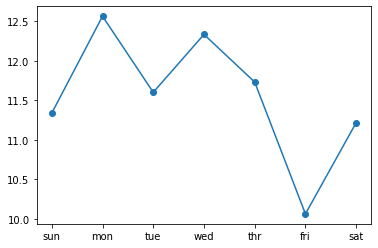

In [ ]:
# multichannel multi-step cnn
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
 
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[2:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
 
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)
 
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model
 
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat
 
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores
 
# load the new file
dataset = read_csv(datapath, header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

In [ ]:
score

Out[146]: 11.57405101373954

In [ ]:
np.mean([i**2 for i in scores])

Out[147]: 133.95865686864533

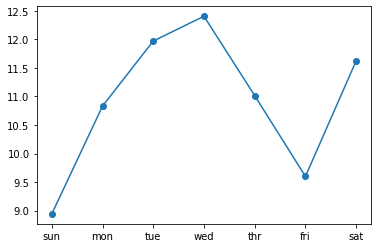

In [ ]:
# multi headed multi-step cnn
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate
 
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[2:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
 
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)
 
# plot training history
def plot_history(history):
	# plot loss
	pyplot.subplot(2, 1, 1)
	pyplot.plot(history.history['loss'], label='train')
	pyplot.plot(history.history['val_loss'], label='test')
	pyplot.title('loss', y=0, loc='center')
	pyplot.legend()
	# plot rmse
	pyplot.subplot(2, 1, 2)
	pyplot.plot(history.history['rmse'], label='train')
	pyplot.plot(history.history['val_rmse'], label='test')
	pyplot.title('rmse', y=0, loc='center')
	pyplot.legend()
	pyplot.show()
 
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 25, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# create a channel for each variable
	in_layers, out_layers = list(), list()
	for i in range(n_features):
		inputs = Input(shape=(n_timesteps,1))
		conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
		conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
		pool1 = MaxPooling1D(pool_size=2)(conv2)
		flat = Flatten()(pool1)
		# store layers
		in_layers.append(inputs)
		out_layers.append(flat)
	# merge heads
	merged = concatenate(out_layers)
	# interpretation
	dense1 = Dense(200, activation='relu')(merged)
	dense2 = Dense(100, activation='relu')(dense1)
	outputs = Dense(n_outputs)(dense2)
	model = Model(inputs=in_layers, outputs=outputs)
	# compile model
	model.compile(loss='mse', optimizer='adam')
 
	# fit network
	input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]
	model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model
 
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into n input arrays
	input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat
 
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores
 
# load the new file
dataset = read_csv(datapath, header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

In [ ]:
score

Out[149]: 10.974273814683638

In [ ]:
np.mean([i**2 for i in scores])

Out[150]: 120.43468575965106